In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

# Load the Data

In [17]:
# result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_complete/"
# with open('/homes/me466/cem/experiments/configs/cub_mixcem_complete.yaml', "r") as f:
#     experiment_config = yaml.load(f, Loader=yaml.FullLoader)

result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_incomplete/"
with open('/homes/me466/cem/experiments/configs/cub_mixcem_incomplete.yaml', "r") as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

# id_dataset_config =  {
#     "dataset": "awa2",
#     "num_workers": 8,
#     "batch_size": 512,

#     # DATASET VARIABLES
#     "root_dir": "/anfs/bigdisc/me466/AwA2/Animals_with_Attributes2",
#     "sampling_percent": 0.1,
#     "sampling_groups": False,
#     "test_subsampling": 1,
#     "weight_loss": False,
# }

id_dataset_config =  {
    "dataset": "cub",
    "num_workers": 8,
    "batch_size": 64,

    # DATASET VARIABLES
    "root_dir": "/homes/me466/data/CUB200/",
    "sampling_percent": 0.25 if "cub_incomplete" in result_dir else 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": True,
}

In [18]:
import cem.utils.data as data_utils
# import cem.data.awa2_loader as data_module
import cem.data.CUB200.cub_loader as data_module
from cem.data.utils import transform_from_config

test_transform_config = dict(
    name='salt_and_pepper',
    s_vs_p=0.5,
    amount=0.25,
)

# test_transform_config = dict(
#     name='random_noise',
#     low_noise_level=1,
#     noise_level=0.5,
# )

test_transform_fn = transform_from_config(test_transform_config)
_, _, id_test_dl, _, (n_concepts, n_tasks, concept_map) = \
    data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
    )
id_x_test, id_y_test, id_c_test = data_utils.daloader_to_memory(id_test_dl)


_, _, ood_test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    data_module.generate_data(
        config=id_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=id_dataset_config.get('root_dir', None),
        test_sample_transform=test_transform_fn,
    )
ood_x_test, ood_y_test, ood_c_test = data_utils.daloader_to_memory(ood_test_dl)

Global seed set to 42


		Selected concepts: [0, 1, 2, 3, 37, 38, 39, 40, 41, 42, 43, 44, 51, 52, 76, 77, 86, 87, 88, 99, 100, 101]
		Updated concept group map (with 7 groups):
			has_bill_shape -> [0, 1, 2, 3]
			has_head_pattern -> [4, 5]
			has_breast_color -> [6, 7, 8, 9, 10, 11]
			has_bill_length -> [12, 13]
			has_wing_shape -> [14, 15]
			has_tail_pattern -> [16, 17, 18]
			has_bill_color -> [19, 20, 21]


Global seed set to 42


		Selected concepts: [0, 1, 2, 3, 37, 38, 39, 40, 41, 42, 43, 44, 51, 52, 76, 77, 86, 87, 88, 99, 100, 101]
		Updated concept group map (with 7 groups):
			has_bill_shape -> [0, 1, 2, 3]
			has_head_pattern -> [4, 5]
			has_breast_color -> [6, 7, 8, 9, 10, 11]
			has_bill_length -> [12, 13]
			has_wing_shape -> [14, 15]
			has_tail_pattern -> [16, 17, 18]
			has_bill_color -> [19, 20, 21]


# Load the Models to be Used

In [19]:
import experiments.experiment_utils as experiment_utils
import joblib
split = 0
selected_models = joblib.load(
    os.path.join(result_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'),
)

In [20]:
models_to_include = [
    ("Hybrid CBM", "Hybrid-CBM (Baseline)"),
    ("CEM", "CEM (Baseline)"),
    ("IntCEM", "IntCEM (Baseline)"),
    ("MixCEM", "MixCEM Final All (Baseline)"),
]

# Generate the Bottlenecks

In [21]:
from cem.models.construction import load_trained_model
import pytorch_lightning as pl

id_y_preds = []
id_c_preds = []
id_bottlenecks = []

id_int_y_preds = []
id_int_c_preds = []
id_int_bottlenecks = []

ood_y_preds = []
ood_c_preds = []
ood_bottlenecks = []
ood_int_y_preds = []
ood_int_c_preds = []
ood_int_bottlenecks = []

for real_model_name, used_model_name in models_to_include:
    root = selected_models[used_model_name]
    model_config = joblib.load(
        os.path.join(result_dir, root + "_experiment_config.joblib"),
    )

    task_class_weights = None
    model = load_trained_model(
        config=model_config,
        n_tasks=n_tasks,
        result_dir=result_dir,
        n_concepts=n_concepts,
        split=split,
        imbalance=imbalance,
        task_class_weights=task_class_weights,
        train_dl=None,
        logger=False,
        output_latent=False,
        output_interventions=False,
        enable_checkpointing=False,
    )
    trainer = pl.Trainer(
        gpus=1,
        logger=False,
    )

    print("Unintervened ID Bottlenecks for", real_model_name)
    id_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )

    id_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))
    id_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))
    id_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), id_test_batch_results)),
        axis=0,
    ))

    print("Unintervened OOD Bottlenecks for", real_model_name)
    ood_test_batch_results = trainer.predict(
        model,
        ood_test_dl,
    )
    ood_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))
    ood_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))
    ood_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), ood_test_batch_results)),
        axis=0,
    ))

    model.force_all_interventions = True
    print("Intervened ID Bottlenecks for", real_model_name)
    id_int_test_batch_results = trainer.predict(
        model,
        id_test_dl,
    )

    id_int_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))
    id_int_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))
    id_int_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), id_int_test_batch_results)),
        axis=0,
    ))

    print("Intervened OOD Bottlenecks for", real_model_name)
    ood_int_test_batch_results = trainer.predict(
        model,
        ood_test_dl,
    )
    ood_int_c_preds.append(np.concatenate(
        list(map(lambda x: x[0].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))
    ood_int_bottlenecks.append(np.concatenate(
        list(map(lambda x: x[1].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))
    ood_int_y_preds.append(np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), ood_int_test_batch_results)),
        axis=0,
    ))

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for Hybrid CBM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for CEM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for IntCEM


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened ID Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Unintervened OOD Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened ID Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Intervened OOD Bottlenecks for MixCEM


Predicting: 0it [00:00, ?it/s]

# Visualize the Bottlenecks

In [22]:
from sklearn.manifold import TSNE
import random
random.seed(42)
np.random.seed(42)

freq = 10
perplexity = 50
n_iter = 1000
tsne_no_int_bottlenecks = []
tsne_int_bottlenecks = []
used_subset = list(range(0, id_bottlenecks[0].shape[0], freq))
n_samples = len(used_subset)
for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
    print("Projecting bottlenecks for", real_model_name)
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_bottleneck_data =  np.concatenate(
        [
            np.reshape(id_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
            np.reshape(ood_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
        ],
        axis=0,
    )
    tsne_no_int_bottlenecks.append(
        test_tsne.fit_transform(merged_bottleneck_data)
    )

    merged_bottleneck_data =  np.concatenate(
        [
            np.reshape(id_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
            np.reshape(ood_int_bottlenecks[model_idx][used_subset,:], (n_samples, -1)),
        ],
        axis=0,
    )
    tsne_int_bottlenecks.append(
        test_tsne.fit_transform(merged_bottleneck_data)
    )

Projecting bottlenecks for Hybrid CBM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 0.805844


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.998505
[t-SNE] KL divergence after 1000 iterations: 0.935899
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 0.804840


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.041023
[t-SNE] KL divergence after 1000 iterations: 0.942826
Projecting bottlenecks for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 10.091779


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.310600
[t-SNE] KL divergence after 1000 iterations: 1.034979
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 16.954855


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.747940
[t-SNE] KL divergence after 1000 iterations: 0.852518
Projecting bottlenecks for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 7.173541


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.398239
[t-SNE] KL divergence after 1000 iterations: 1.087391
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.000s...
[t-SNE] Computed neighbors for 1160 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 16.077369


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.306839
[t-SNE] KL divergence after 1000 iterations: 0.952891
Projecting bottlenecks for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.001s...
[t-SNE] Computed neighbors for 1160 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 3.092944


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.323463
[t-SNE] KL divergence after 1000 iterations: 1.250072
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1160 samples in 0.001s...
[t-SNE] Computed neighbors for 1160 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1160
[t-SNE] Computed conditional probabilities for sample 1160 / 1160
[t-SNE] Mean sigma: 13.854453


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.733925
[t-SNE] KL divergence after 1000 iterations: 0.715862


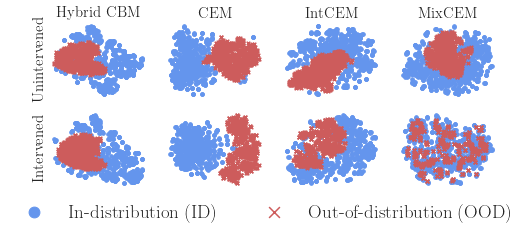

In [24]:
figsize = (2 * len(models_to_include), 3)
fig, axs = plt.subplots(
    2,
    len(models_to_include),
    figsize=figsize,
)

id_color = 'cornflowerblue'
ood_color = 'indianred'

for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
    ax = axs[0, model_idx]
    ax.scatter(
        tsne_no_int_bottlenecks[model_idx][:n_samples, 0],
        tsne_no_int_bottlenecks[model_idx][:n_samples, 1],
        color=id_color,
        label=f"In-distribution (ID)",
        marker='o',
        alpha=1,
        s=13,
    )
    ax.scatter(
        tsne_no_int_bottlenecks[model_idx][n_samples:, 0],
        tsne_no_int_bottlenecks[model_idx][n_samples:, 1],
        color=ood_color,
        label=f"Out-of-distribution (OOD)",
        marker='x',
        alpha=1,
        s=13,
    )

    ax.set_title(real_model_name, fontsize=15)
    if model_idx == 0:
        ax.set_ylabel("Unintervened", fontsize=15)
    ax.grid(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax = axs[1, model_idx]
    ax.scatter(
        tsne_int_bottlenecks[model_idx][:n_samples, 0],
        tsne_int_bottlenecks[model_idx][:n_samples, 1],
        color=id_color,
        label=f"In-distribution (ID)",
        marker='o',
        alpha=1,
        s=13,
    )
    ax.scatter(
        tsne_int_bottlenecks[model_idx][n_samples:, 0],
        tsne_int_bottlenecks[model_idx][n_samples:, 1],
        color=ood_color,
        label=f"Out-of-distribution (OOD)",
        marker='x',
        alpha=1,
        s=13,
    )

    if model_idx == 0:
        ax.set_ylabel("Intervened", fontsize=15)
    ax.grid(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=19,
    loc='upper center',
    bbox_to_anchor=(-1.4,0),
    ncol=2,
    markerscale=3.,
)
plt.savefig(f"figures/bottleneck_intervention_viz.pdf", bbox_inches='tight')
plt.savefig(f"figures/bottleneck_intervention_viz.png", bbox_inches='tight')
plt.savefig(f"figures/paper/bottleneck_intervention_viz.pdf", bbox_inches='tight')
plt.savefig(f"figures/paper/bottleneck_intervention_viz.png", bbox_inches='tight')
plt.show()

# Visualize the actual embeddings

In [25]:
# First we load our mixcem model so that we can include the global embeddings
# as part of the plot
mixcem_root = selected_models["MixCEM Final All (Baseline)"]
mixcem_model_config = joblib.load(
    os.path.join(result_dir, root + "_experiment_config.joblib"),
)

mixcem = load_trained_model(
    config=mixcem_model_config,
    n_tasks=n_tasks,
    result_dir=result_dir,
    n_concepts=n_concepts,
    split=split,
    imbalance=imbalance,
    task_class_weights=task_class_weights,
    train_dl=None,
    logger=False,
    output_latent=False,
    output_interventions=False,
    enable_checkpointing=False,
)


In [34]:
from sklearn.manifold import TSNE
import random
random.seed(42)
np.random.seed(42)

freq = 5 #10
perplexity = 50
n_iter = 1000
selected_concepts = list(range(0, 22))

tsne_int_embeddings = []
for selected_concept in selected_concepts:
    used_subset = list(range(0, id_bottlenecks[0].shape[0], freq))
    n_samples = len(used_subset)
    concept_embs = []
    tsne_int_embeddings.append(concept_embs)
    for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
        if real_model_name == "Hybrid CBM":
            continue
        emb_size = 16
        print("Projecting embedings for", real_model_name)
        test_tsne = TSNE(
            n_components=2,
            verbose=1,
            perplexity=perplexity,
            n_iter=n_iter,
            init='pca',
            learning_rate='auto',
        )
        if real_model_name == "MixCEM":
            merged_bottleneck_data =  np.concatenate(
                [
                    mixcem.concept_embeddings[selected_concept, :, :].detach().cpu().numpy(),
                    id_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,emb_size:2*emb_size],
                    # id_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,:emb_size],
                    ood_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,emb_size:2*emb_size],
                    # ood_int_bottlenecks[model_idx].reshape((5794, 22, 3*emb_size))[used_subset,selected_concept,:emb_size],
                ],
                axis=0,
            )

        else:
            merged_bottleneck_data =  np.concatenate(
                [
                    id_int_bottlenecks[model_idx].reshape((5794, 22, emb_size))[used_subset,selected_concept,:emb_size],
                    ood_int_bottlenecks[model_idx].reshape((5794, 22, emb_size))[used_subset,selected_concept,:emb_size],
                ],
                axis=0,
            )
        concept_embs.append(
            test_tsne.fit_transform(merged_bottleneck_data)
        )

Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.484872


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.019165
[t-SNE] KL divergence after 1000 iterations: 1.103603
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.172226


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.084663
[t-SNE] KL divergence after 1000 iterations: 0.896860
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.292593


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.823204
[t-SNE] KL divergence after 1000 iterations: 0.920188
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.796279


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.960747
[t-SNE] KL divergence after 1000 iterations: 1.202008
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.091054


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.635307
[t-SNE] KL divergence after 1000 iterations: 1.137515
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.140314


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.812050
[t-SNE] KL divergence after 1000 iterations: 1.042786
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.111822


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.778961
[t-SNE] KL divergence after 1000 iterations: 0.933537
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.417856


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.404472
[t-SNE] KL divergence after 1000 iterations: 0.976737
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.000224


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.571743
[t-SNE] KL divergence after 1000 iterations: 0.558470
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.760703


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.091080
[t-SNE] KL divergence after 1000 iterations: 0.996305
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.269720


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.616821
[t-SNE] KL divergence after 1000 iterations: 1.038551
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.113759


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.130386
[t-SNE] KL divergence after 1000 iterations: 0.762084
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.326342


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.633156
[t-SNE] KL divergence after 1000 iterations: 1.206227
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.508951


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.986725
[t-SNE] KL divergence after 1000 iterations: 1.246295
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.087177


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.155296
[t-SNE] KL divergence after 1000 iterations: 0.999266
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.881168


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.807320
[t-SNE] KL divergence after 1000 iterations: 1.072372
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.357629


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.852859
[t-SNE] KL divergence after 1000 iterations: 0.986430
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.003127


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.746223
[t-SNE] KL divergence after 1000 iterations: 0.687903
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.367687


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.734871
[t-SNE] KL divergence after 1000 iterations: 1.177457
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 0.845004


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.463654
[t-SNE] KL divergence after 1000 iterations: 0.915853
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.197508


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.415703
[t-SNE] KL divergence after 1000 iterations: 0.967572
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.831356


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.786552
[t-SNE] KL divergence after 1000 iterations: 1.324612
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.134778


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.563019
[t-SNE] KL divergence after 1000 iterations: 1.069898
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.092049


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.433205
[t-SNE] KL divergence after 1000 iterations: 0.981421
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.275549


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.668617
[t-SNE] KL divergence after 1000 iterations: 1.169843
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.070609


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.800110
[t-SNE] KL divergence after 1000 iterations: 1.153859
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.187697


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.422218
[t-SNE] KL divergence after 1000 iterations: 0.852306
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.827492


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.206207
[t-SNE] KL divergence after 1000 iterations: 1.200384
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 0.968258


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.159500
[t-SNE] KL divergence after 1000 iterations: 1.016362
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.034803


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.860031
[t-SNE] KL divergence after 1000 iterations: 0.745907
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.161273


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.532387
[t-SNE] KL divergence after 1000 iterations: 0.967505
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.473516


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.937828
[t-SNE] KL divergence after 1000 iterations: 0.982632
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.000191


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.720108
[t-SNE] KL divergence after 1000 iterations: 0.652808
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.548676


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.885880
[t-SNE] KL divergence after 1000 iterations: 1.144257
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.051085


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.014343
[t-SNE] KL divergence after 1000 iterations: 1.040971
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.043333


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.407757
[t-SNE] KL divergence after 1000 iterations: 0.888836
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.525731


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.432007
[t-SNE] KL divergence after 1000 iterations: 1.018067
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.166011


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.613449
[t-SNE] KL divergence after 1000 iterations: 1.031774
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.006198


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.226135
[t-SNE] KL divergence after 1000 iterations: 0.613706
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 0.202517


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.028854
[t-SNE] KL divergence after 1000 iterations: 0.749481
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.248940


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.204113
[t-SNE] KL divergence after 1000 iterations: 0.925448
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.001234


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.361034
[t-SNE] KL divergence after 1000 iterations: 0.656829
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.001s...
[t-SNE] Computed neighbors for 2318 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.189292


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.802155
[t-SNE] KL divergence after 1000 iterations: 0.937187
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.447135


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.621300
[t-SNE] KL divergence after 1000 iterations: 1.084040
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.000103


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.573673
[t-SNE] KL divergence after 1000 iterations: 0.490001
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 2.191618


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.919746
[t-SNE] KL divergence after 1000 iterations: 1.223533
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.018701


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.368347
[t-SNE] KL divergence after 1000 iterations: 0.972757
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.042053


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.449318
[t-SNE] KL divergence after 1000 iterations: 0.813802
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.018686


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.709248
[t-SNE] KL divergence after 1000 iterations: 0.958864
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.020837


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.852428
[t-SNE] KL divergence after 1000 iterations: 0.856609
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.000924


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.214615
[t-SNE] KL divergence after 1000 iterations: 0.559782
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.679555


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.691696
[t-SNE] KL divergence after 1000 iterations: 1.219782
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.110296


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.927048
[t-SNE] KL divergence after 1000 iterations: 1.057478
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.161944


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.044281
[t-SNE] KL divergence after 1000 iterations: 0.936800
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.001s...
[t-SNE] Computed neighbors for 2318 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 2.042042


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.249466
[t-SNE] KL divergence after 1000 iterations: 1.202348
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 0.976254


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.706177
[t-SNE] KL divergence after 1000 iterations: 1.010980
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.079581


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.784523
[t-SNE] KL divergence after 1000 iterations: 0.923482
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 2.058881


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.903381
[t-SNE] KL divergence after 1000 iterations: 1.366386
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.194239


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.061600
[t-SNE] KL divergence after 1000 iterations: 1.048721
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.056543


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.623684
[t-SNE] KL divergence after 1000 iterations: 0.882745
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 0.904686


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.954922
[t-SNE] KL divergence after 1000 iterations: 0.868644
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.361894


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.731750
[t-SNE] KL divergence after 1000 iterations: 0.975248
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.001236


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.535431
[t-SNE] KL divergence after 1000 iterations: 0.546041
Projecting embedings for CEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.566384


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.135025
[t-SNE] KL divergence after 1000 iterations: 1.137968
Projecting embedings for IntCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2318 samples in 0.000s...
[t-SNE] Computed neighbors for 2318 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2318
[t-SNE] Computed conditional probabilities for sample 2000 / 2318
[t-SNE] Computed conditional probabilities for sample 2318 / 2318
[t-SNE] Mean sigma: 1.418200


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.825363
[t-SNE] KL divergence after 1000 iterations: 1.159330
Projecting embedings for MixCEM
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2320 samples in 0.000s...
[t-SNE] Computed neighbors for 2320 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2320
[t-SNE] Computed conditional probabilities for sample 2000 / 2320
[t-SNE] Computed conditional probabilities for sample 2320 / 2320
[t-SNE] Mean sigma: 0.280713


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.812813
[t-SNE] KL divergence after 1000 iterations: 1.072294


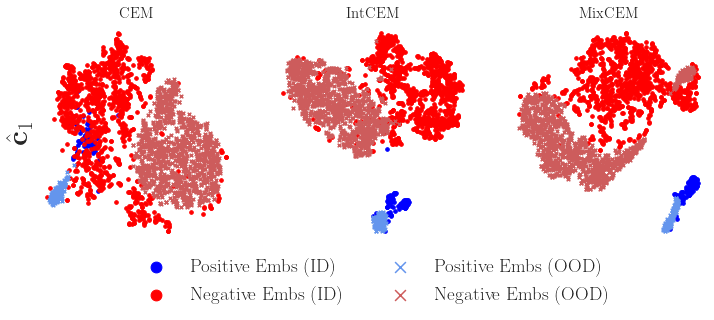

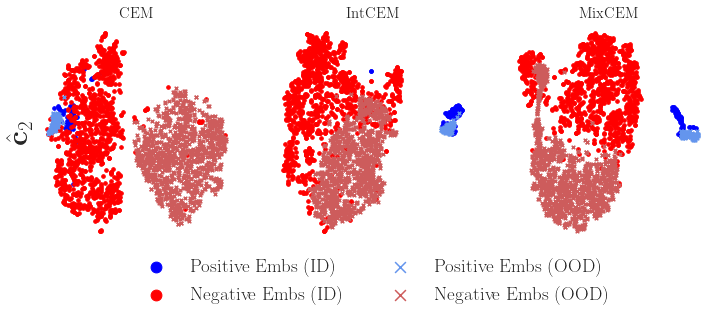

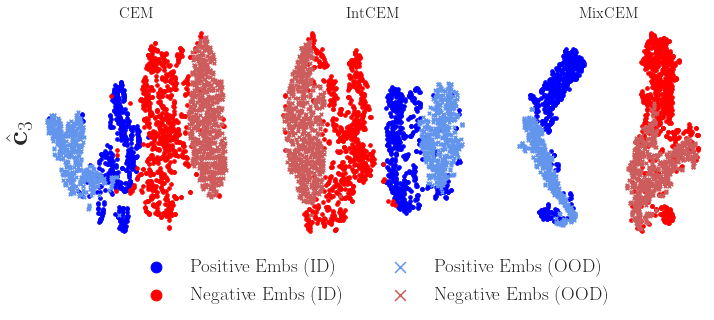

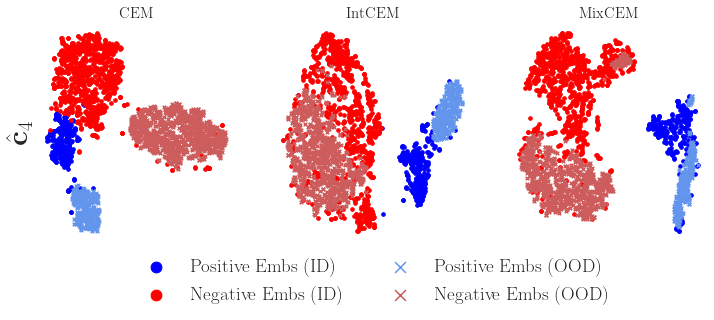

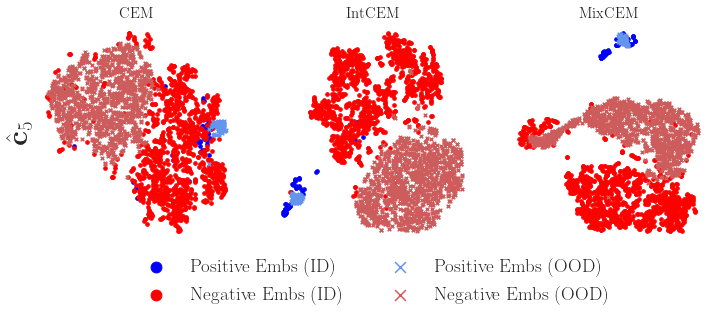

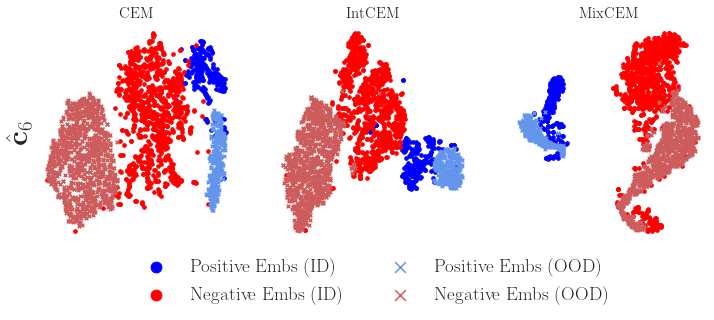

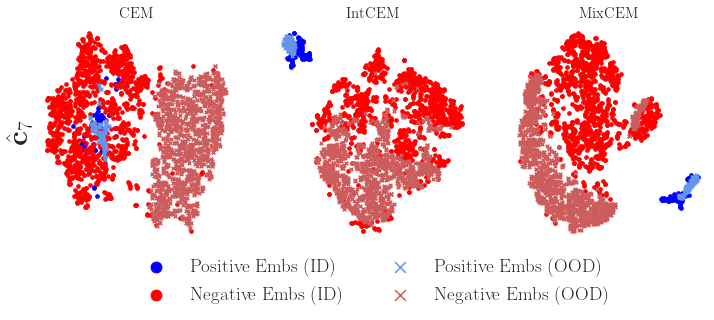

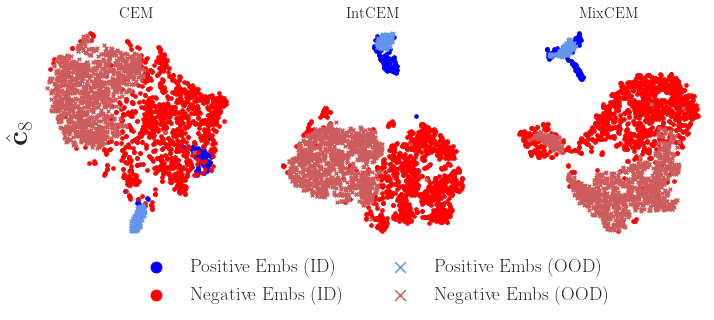

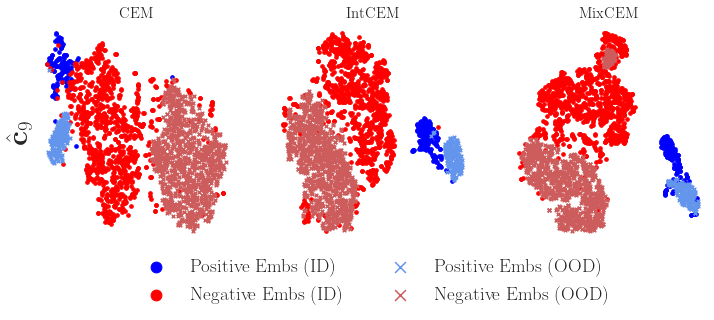

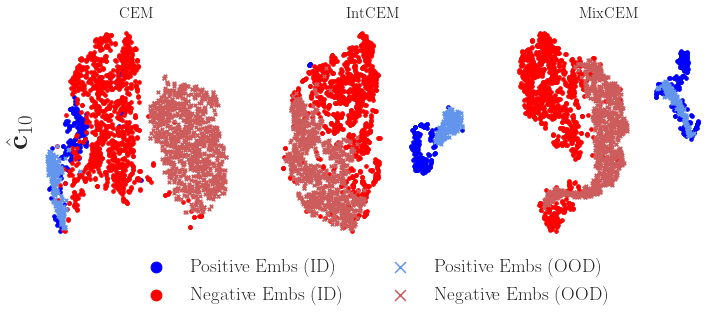

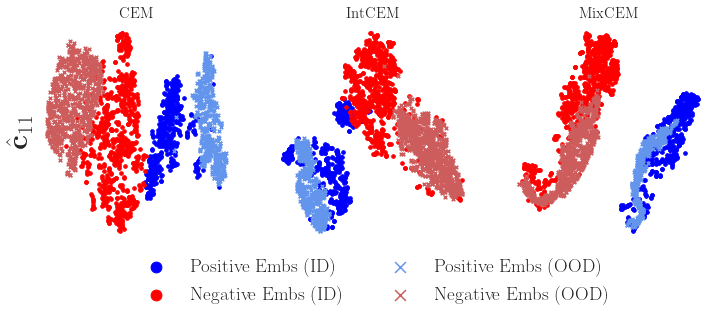

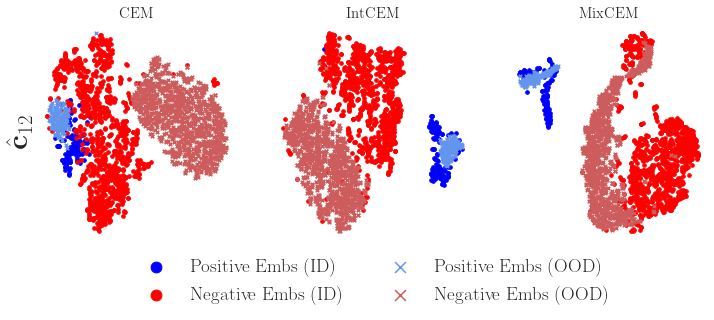

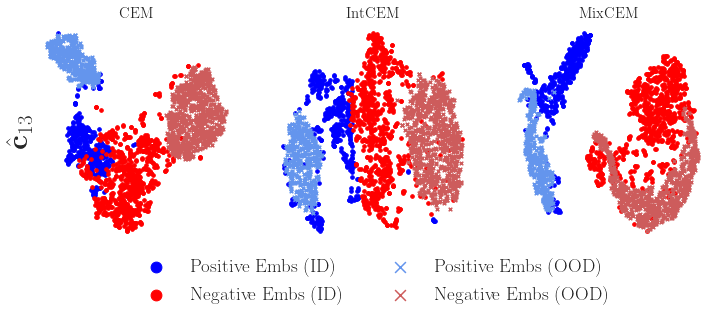

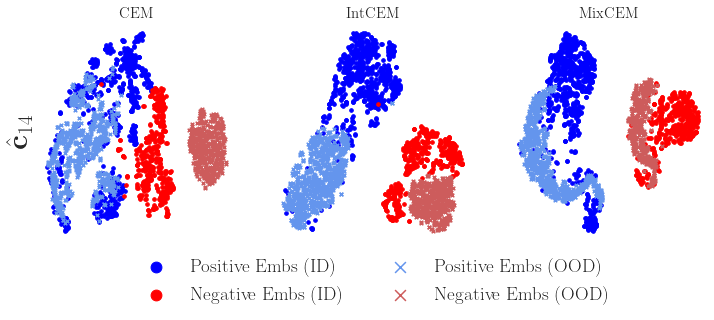

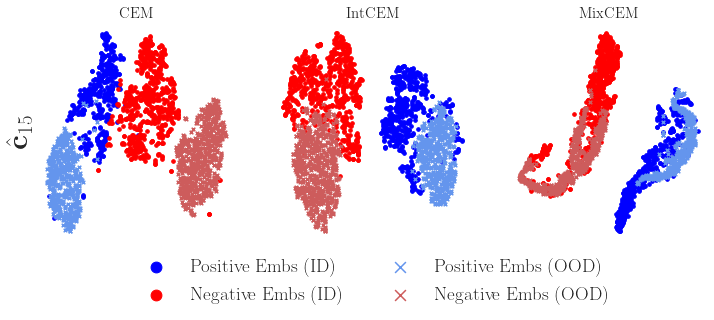

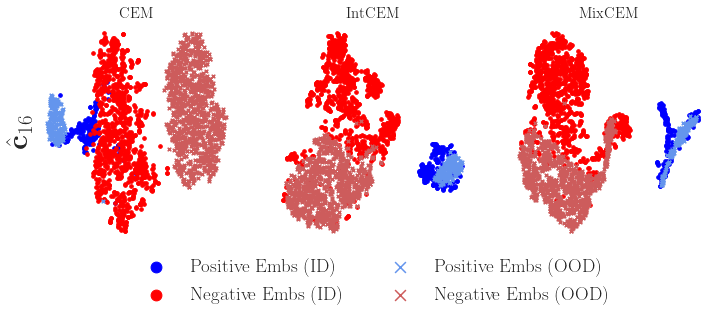

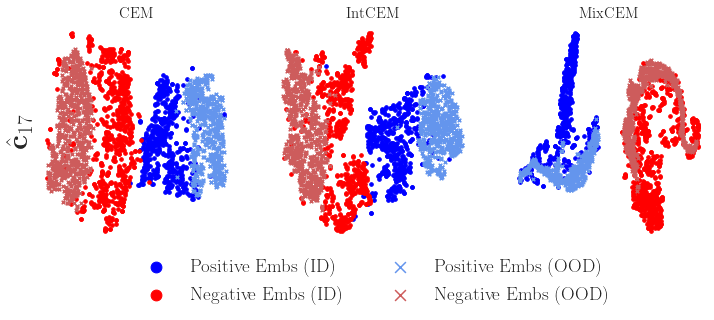

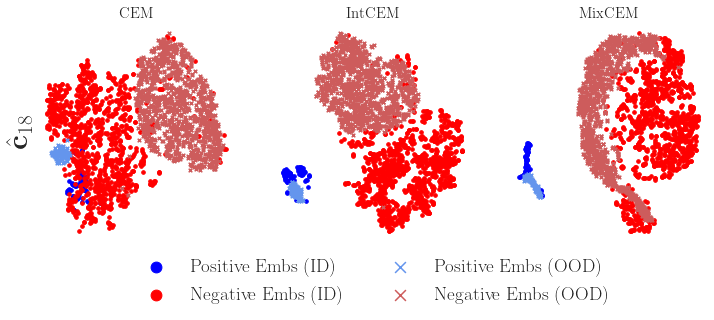

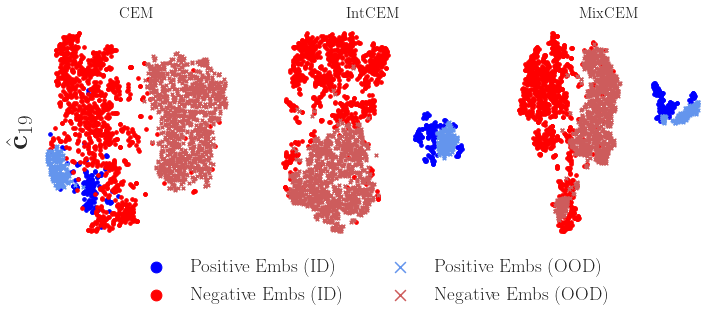

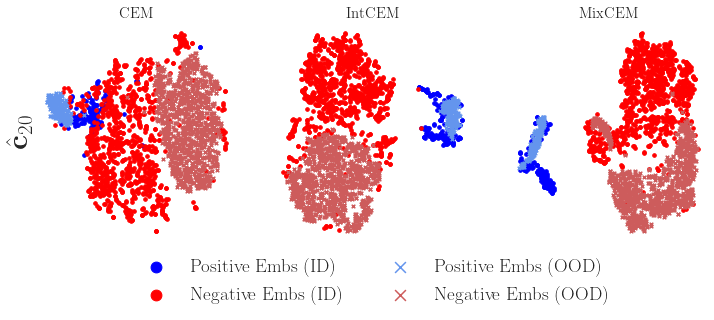

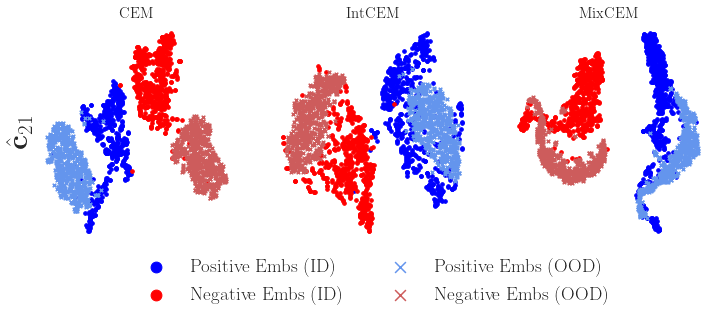

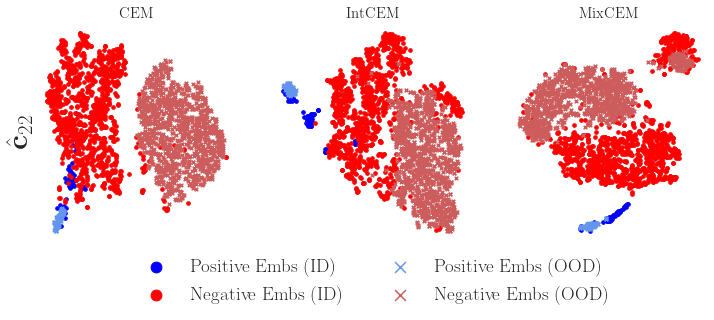

In [35]:
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS

# Now plot things!
for selected_concept, used_embeddings in zip(selected_concepts, tsne_int_embeddings):

    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]

    activation_label = f"Embeddings for {concept_name}"

    mask = id_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    figsize = (4 * (len(models_to_include) - 1), 4)
    fig, axs = plt.subplots(
        1,
        (len(models_to_include) - 1),
        figsize=figsize,
        squeeze=False,
    )

    id_color_active = 'blue'
    ood_color_active = 'cornflowerblue'
    id_color_inactive = 'red'
    ood_color_inactive = 'indianred'
    ignored = 0
    for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
        if real_model_name == 'Hybrid CBM':
            ignored += 1
            continue
        start_idx = 0
        if real_model_name == 'MixCEM':
            start_idx = 2
        model_idx -= ignored
        # n_samples = (used_embeddings[model_idx].shape[0] - start_idx)
        # ax = axs[0, model_idx]
        # ax.scatter(
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][mask],
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][mask],
        #     color=id_color_active,
        #     label=f"Positive Embs (OOD)",
        #     marker='o',
        #     alpha=1,
        #     s=13,
        # )
        # ax.scatter(
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][neg_mask],
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][neg_mask],
        #     color=id_color_inactive,
        #     label=f"Negative Embs (OOD)",
        #     marker='o',
        #     alpha=1,
        #     s=13,
        # )
        
        n_samples = (used_embeddings[model_idx].shape[0] - start_idx)//2
        ax = axs[0, model_idx]
        ax.scatter(
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][mask],
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][mask],
            color=id_color_active,
            label=f"Positive Embs (ID)",
            marker='o',
            alpha=1,
            s=13,
        )
        ax.scatter(
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][neg_mask],
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][neg_mask],
            color=id_color_inactive,
            label=f"Negative Embs (ID)",
            marker='o',
            alpha=1,
            s=13,
        )

        ax.scatter(
            used_embeddings[model_idx][start_idx + n_samples:, 0][mask],
            used_embeddings[model_idx][start_idx + n_samples:, 1][mask],
            color=ood_color_active,
            label=f"Positive Embs (OOD)",
            marker='x',
            alpha=1,
            s=13,
        )

        ax.scatter(
            used_embeddings[model_idx][start_idx + n_samples:, 0][neg_mask],
            used_embeddings[model_idx][start_idx + n_samples:, 1][neg_mask],
            color=ood_color_inactive,
            label=f"Negative Embs (OOD)",
            marker='x',
            alpha=1,
            s=13,
        )
        # print("used_embeddings[model_idx].shape =", used_embeddings[model_idx].shape)
        # if real_model_name == "MixCEM":
        #     # Then also plot the global embeddings!
        #     # And plot the global embeddings
        #     ax.scatter(
        #         used_embeddings[model_idx][0:1, 0],
        #         used_embeddings[model_idx][0:1, 1],
        #         color='blue',
        #         # label=r"Positive Global Embedding $\bar{\mathbf{c}}^{(+)}_i$",
        #         marker='*',
        #         s=300,
        #         edgecolor='black',
        #         linewidths=2,
        #     )

        #     ax.scatter(
        #          used_embeddings[model_idx][1:2, 0],
        #          used_embeddings[model_idx][1:2, 1],
        #         color='red',
        #         # label=r"$Negative Global Embedding \bar{\mathbf{c}}^{(-)}_i$",
        #         marker='*',
        #         s=300,
        #         edgecolor='black',
        #         linewidths=2,
        #     )

        ax.set_title(real_model_name, fontsize=15)
        if model_idx == 0:
            ax.set_ylabel("$\hat{\mathbf{c}}_{" +str(selected_concept + 1) + "}$", fontsize=30)
        ax.grid(False)
        # Remove the axis line, ticks, and tick labels for the x-axis
        ax.xaxis.set_ticks([])  # Remove tick marks
        ax.xaxis.set_ticklabels([])  # Remove tick labels
        ax.spines['bottom'].set_visible(False)  # Hide the axis line
        ax.spines['top'].set_visible(False)  # Hide the axis line

        # Remove the axis line, ticks, and tick labels for the y-axis (optional)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=19,
        loc='upper center',
        bbox_to_anchor=(-0.7,0),
        ncol=2,
        markerscale=3.,
    )
    plt.savefig(f"figures/concept_embedding_viz.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_embedding_viz.png", bbox_inches='tight')
    plt.show()

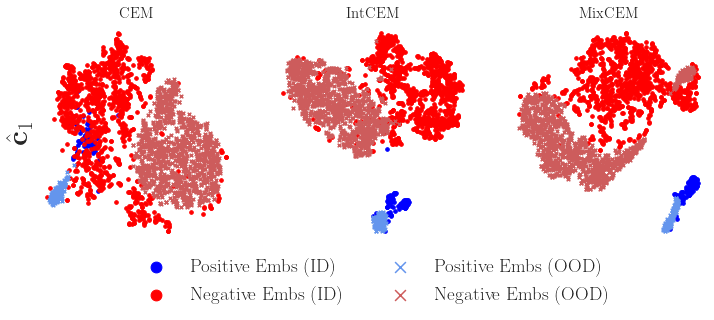

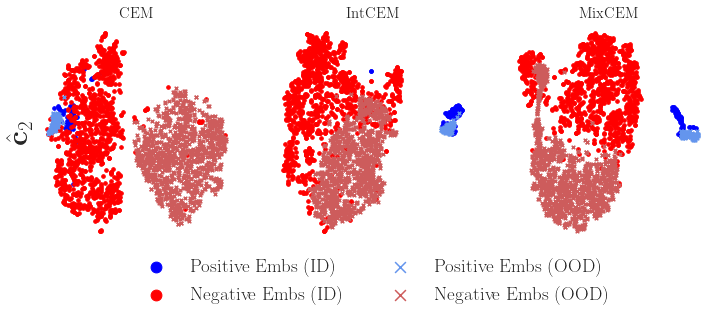

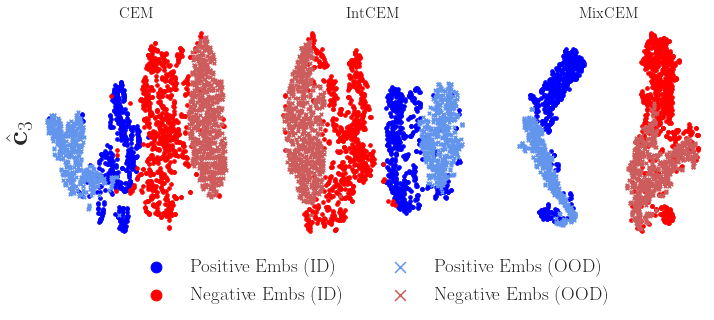

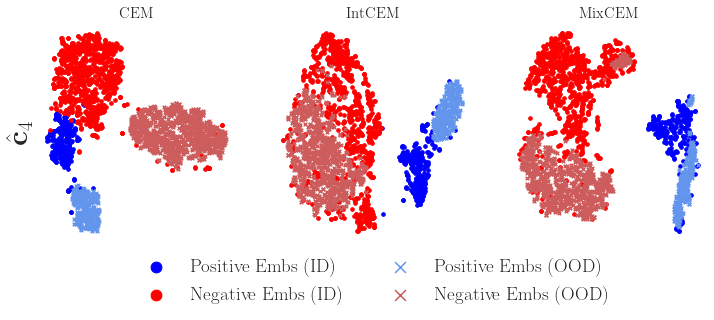

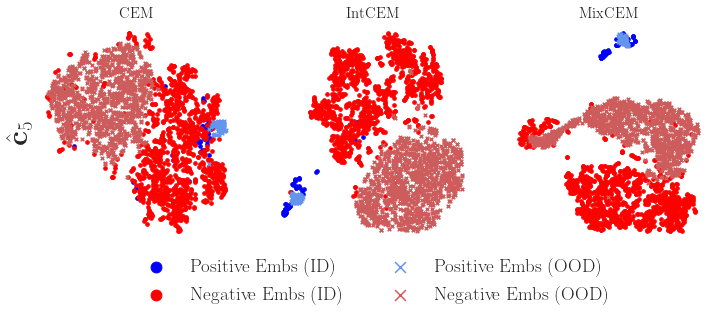

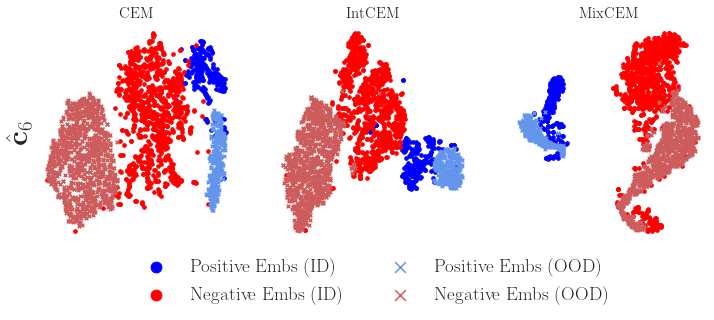

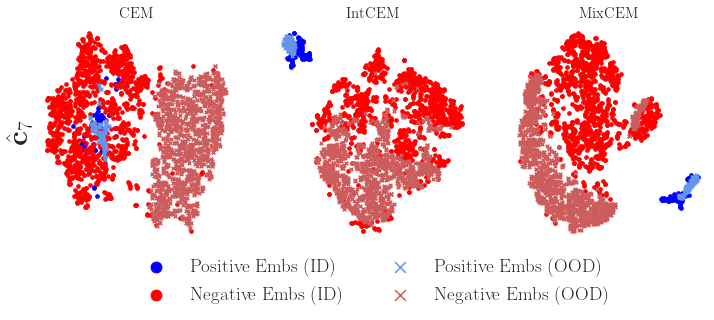

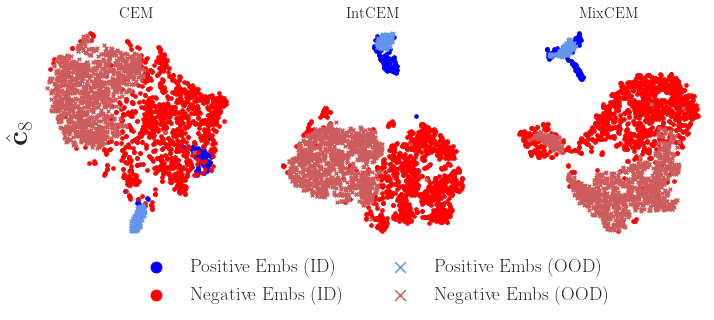

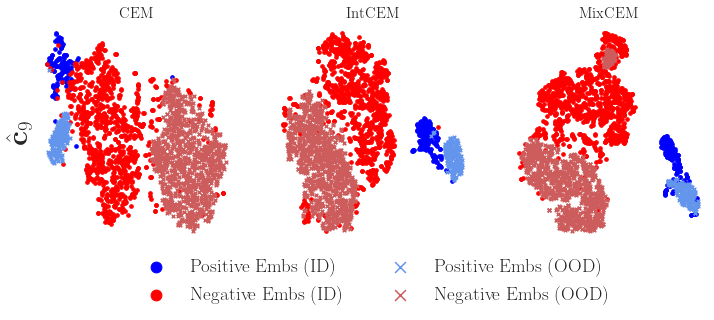

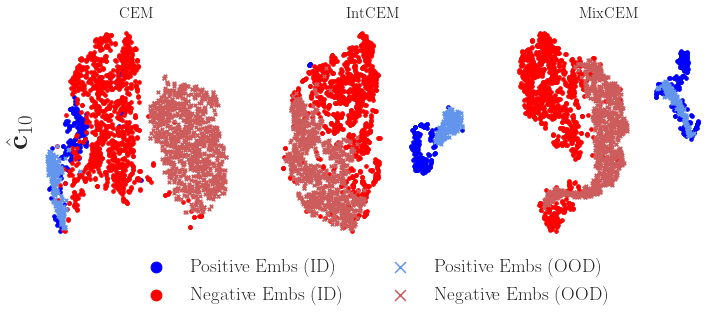

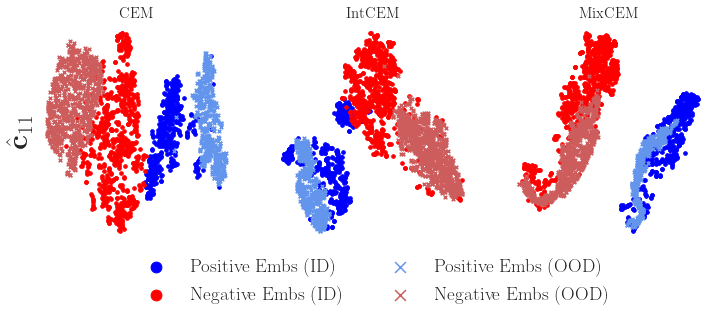

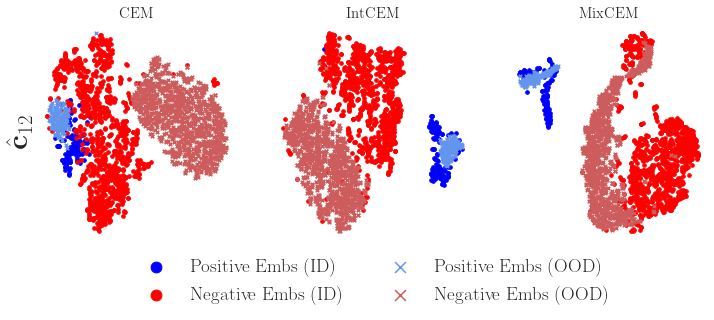

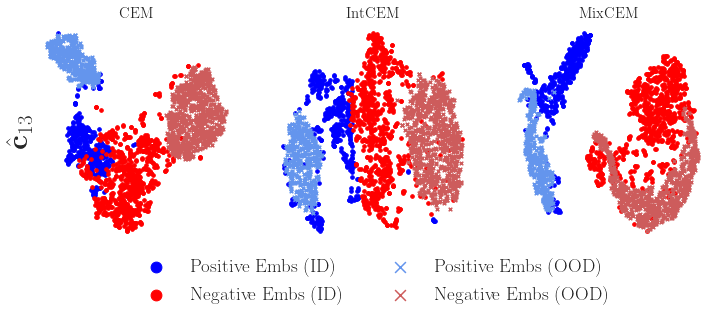

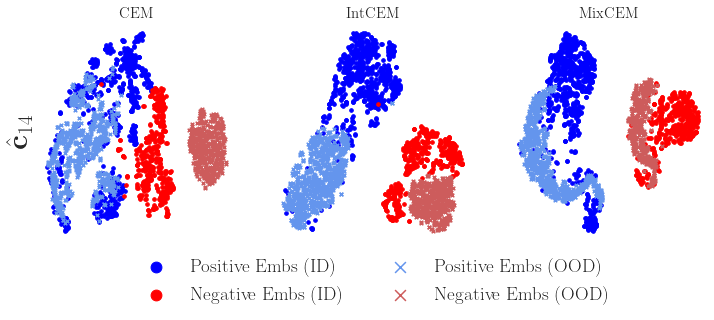

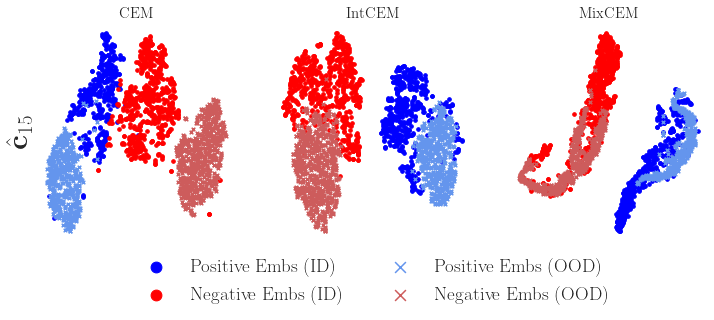

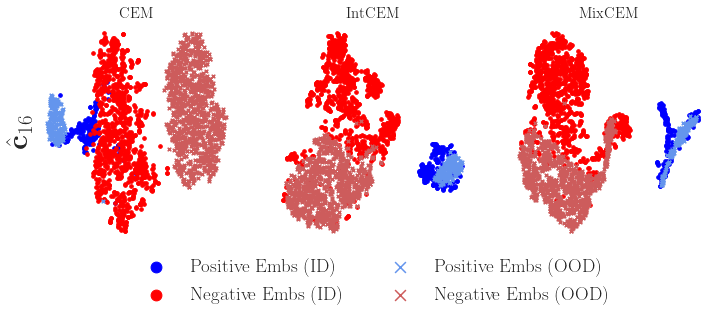

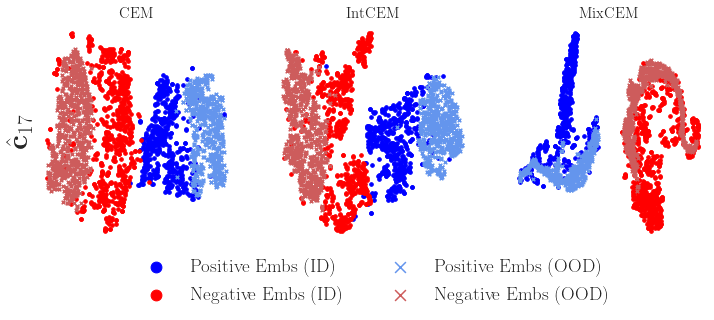

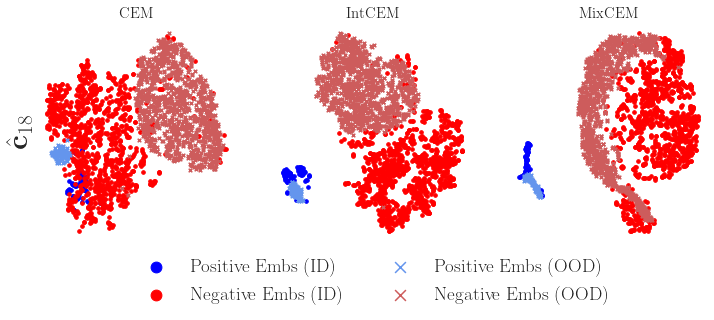

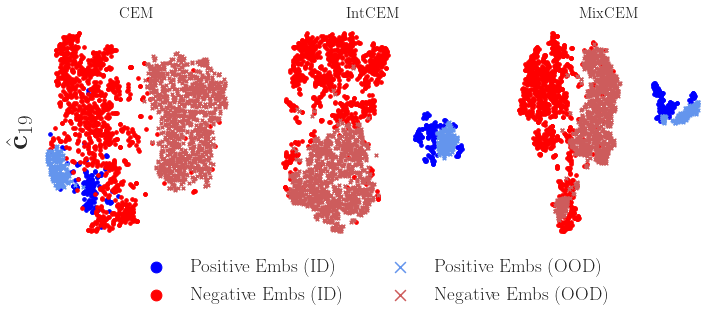

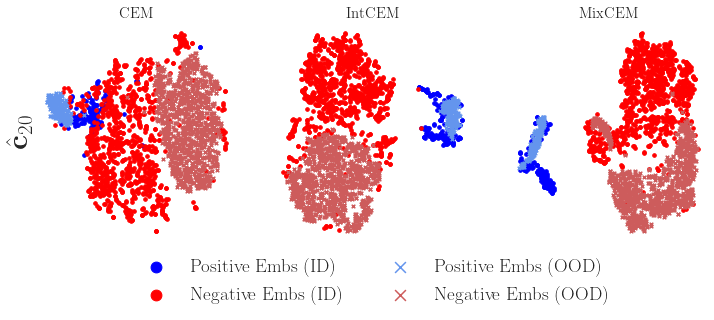

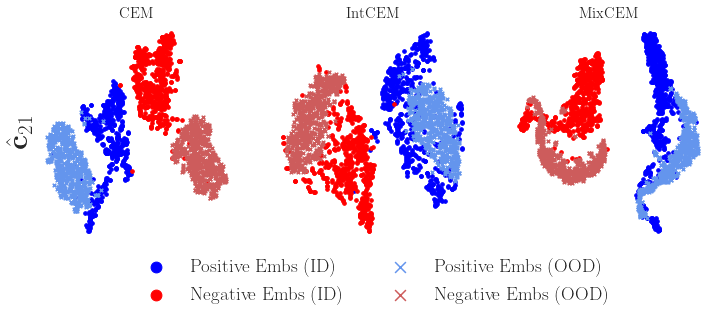

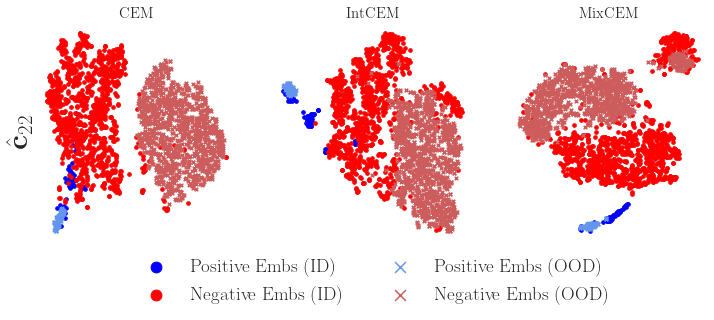

In [36]:
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS

# Now plot things!
for selected_concept, used_embeddings in zip(selected_concepts, tsne_int_embeddings):

    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]

    activation_label = f"Embeddings for {concept_name}"

    mask = id_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    figsize = (4 * (len(models_to_include) - 1), 4)
    fig, axs = plt.subplots(
        1,
        (len(models_to_include) - 1),
        figsize=figsize,
        squeeze=False,
    )

    id_color_active = 'blue'
    ood_color_active = 'cornflowerblue'
    id_color_inactive = 'red'
    ood_color_inactive = 'indianred'
    ignored = 0
    for model_idx, (real_model_name, used_model_name) in enumerate(models_to_include):
        if real_model_name == 'Hybrid CBM':
            ignored += 1
            continue
        start_idx = 0
        if real_model_name == 'MixCEM':
            start_idx = 2
        model_idx -= ignored
        # n_samples = (used_embeddings[model_idx].shape[0] - start_idx)
        # ax = axs[0, model_idx]
        # ax.scatter(
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][mask],
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][mask],
        #     color=id_color_active,
        #     label=f"Positive Embs (OOD)",
        #     marker='o',
        #     alpha=1,
        #     s=13,
        # )
        # ax.scatter(
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][neg_mask],
        #     used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][neg_mask],
        #     color=id_color_inactive,
        #     label=f"Negative Embs (OOD)",
        #     marker='o',
        #     alpha=1,
        #     s=13,
        # )
        
        n_samples = (used_embeddings[model_idx].shape[0] - start_idx)//2
        ax = axs[0, model_idx]
        ax.scatter(
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][mask],
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][mask],
            color=id_color_active,
            label=f"Positive Embs (ID)",
            marker='o',
            alpha=1,
            s=13,
        )
        ax.scatter(
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 0][neg_mask],
            used_embeddings[model_idx][start_idx:n_samples + start_idx, 1][neg_mask],
            color=id_color_inactive,
            label=f"Negative Embs (ID)",
            marker='o',
            alpha=1,
            s=13,
        )

        ax.scatter(
            used_embeddings[model_idx][start_idx + n_samples:, 0][mask],
            used_embeddings[model_idx][start_idx + n_samples:, 1][mask],
            color=ood_color_active,
            label=f"Positive Embs (OOD)",
            marker='x',
            alpha=1,
            s=13,
        )

        ax.scatter(
            used_embeddings[model_idx][start_idx + n_samples:, 0][neg_mask],
            used_embeddings[model_idx][start_idx + n_samples:, 1][neg_mask],
            color=ood_color_inactive,
            label=f"Negative Embs (OOD)",
            marker='x',
            alpha=1,
            s=13,
        )
        # print("used_embeddings[model_idx].shape =", used_embeddings[model_idx].shape)
        # if real_model_name == "MixCEM":
        #     # Then also plot the global embeddings!
        #     # And plot the global embeddings
        #     ax.scatter(
        #         used_embeddings[model_idx][0:1, 0],
        #         used_embeddings[model_idx][0:1, 1],
        #         color='blue',
        #         # label=r"Positive Global Embedding $\bar{\mathbf{c}}^{(+)}_i$",
        #         marker='*',
        #         s=300,
        #         edgecolor='black',
        #         linewidths=2,
        #     )

        #     ax.scatter(
        #          used_embeddings[model_idx][1:2, 0],
        #          used_embeddings[model_idx][1:2, 1],
        #         color='red',
        #         # label=r"$Negative Global Embedding \bar{\mathbf{c}}^{(-)}_i$",
        #         marker='*',
        #         s=300,
        #         edgecolor='black',
        #         linewidths=2,
        #     )

        ax.set_title(real_model_name, fontsize=15)
        if model_idx == 0:
            ax.set_ylabel("$\hat{\mathbf{c}}_{" +str(selected_concept + 1) + "}$", fontsize=30)
        ax.grid(False)
        # Remove the axis line, ticks, and tick labels for the x-axis
        ax.xaxis.set_ticks([])  # Remove tick marks
        ax.xaxis.set_ticklabels([])  # Remove tick labels
        ax.spines['bottom'].set_visible(False)  # Hide the axis line
        ax.spines['top'].set_visible(False)  # Hide the axis line

        # Remove the axis line, ticks, and tick labels for the y-axis (optional)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=19,
        loc='upper center',
        bbox_to_anchor=(-0.7,0),
        ncol=2,
        markerscale=3.,
    )
    plt.savefig(f"figures/concept_embs/concept_embedding_viz_{selected_concept}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_embs/concept_embedding_viz_{selected_concept}.png", bbox_inches='tight')
    plt.show()